In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt

### Open the Gathered Data CSV File

In [2]:
dtypes={'Kernel Name':'string', 
        'traffic':np.float64,
        'dpAI':np.float64,
        'spAI':np.float64,
        'dpPerf':np.float64,
        'spPerf':np.float64,
        'xtime':np.float64,
        'Block Size': 'string',
        'Grid Size': 'string',
        'device': 'string',
        "intops": np.float64, 
        "intPerf" : np.float64,
        "intAI": np.float64,
        'targetName': 'string',
        'exeArgs': 'string',
        'kernelName': 'string',
        }
df = pd.read_csv('../roofline-data.csv', quotechar='"', dtype=dtypes)

In [3]:
print(df.shape)
print(df.columns)
print(df.dtypes)

(1248, 16)
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName'],
      dtype='object')
Kernel Name    string[python]
traffic               float64
dpAI                  float64
spAI                  float64
dpPerf                float64
spPerf                float64
xtime                 float64
Block Size     string[python]
Grid Size      string[python]
device         string[python]
intops                float64
intPerf               float64
intAI                 float64
targetName     string[python]
exeArgs        string[python]
kernelName     string[python]
dtype: object


### Let's drop rows with NULL values and fix exeArgs that got a NaN value because they didn't have exeArgs

These were executions that yielded no performance counter data (i.e: they didn't do single/double precision floating point operations).

In [ ]:
df = df[df['Kernel Name'].notna()] 

print(df.shape)

# let's also replace exeArgs that are NaN with ''
df['exeArgs'] = df['exeArgs'].fillna('')

#print(df[df['targetName'] == 'bspline-vgh-cuda'])
#df['exeArgs'] = df['exeArgs'].apply(lambda x: '' if x == 'NULL' else x )

#print(df.dtypes)

# NOTE: WE'RE ONLY SHOWING OpenMP Data in the plots below
# the data is technically incomplete, as we had to kill many runs that took too long
# keep only runs that have a targetName that includes '-omp'
df = df[df['targetName'].str.contains('-omp')]
print(df.shape)

(1243, 16)
(1105, 16)


### Scale the Performance Data

Here we scale down the `spPerf` and `dpPerf` columns to be on the scale of 1e11 (like how it's done in `ncu`).

In [5]:
df['dpPerf'] = df['dpPerf']*(1e-11)
df['spPerf'] = df['spPerf']*(1e-11)
df['intPerf'] = df['intPerf']*(1e-11)

### Let's plot what we have so far

We have double and single precision FLOP data, so we're going to have two plots.

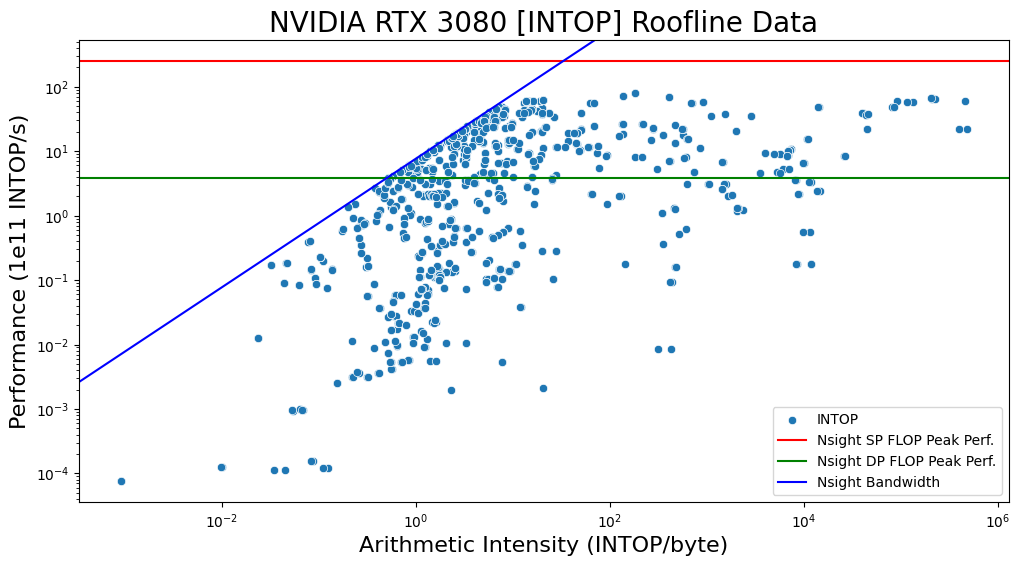

In [ ]:
# it should be noted that samples with dpAI=0 and dpPerf=0 will not show on this plot

# Interesting question: why does the INTOP data fit the same FLOP roofline??
# are the ALUs for FLOP and INTOP tightly-coupled?

fig, ax = plt.subplots(1, figsize=(12,6))

sns.scatterplot(df, x='intAI', y='intPerf', ax=ax)
#sns.scatterplot(df, x='dpAI', y='dpPerf', ax=ax)


ax.axhline(249.6,color='red')
ax.axhline(3.9,color='green')

ax.axline(xy1=(0.51,3.9), xy2=(32.94, 249.6), color='blue')


ax.set_yscale('log')
ax.set_xscale('log')

ax.set_title('NVIDIA RTX 3080 [INTOP] Roofline Data', fontsize=20)

ax.set_xlabel('Arithmetic Intensity (INTOP/byte)', fontsize=16)
ax.set_ylabel('Performance (1e11 INTOP/s)', fontsize=16)

ax.legend(['INTOP', 'Nsight SP FLOP Peak Perf.', 'Nsight DP FLOP Peak Perf.', 'Nsight Bandwidth'])

plt.show()

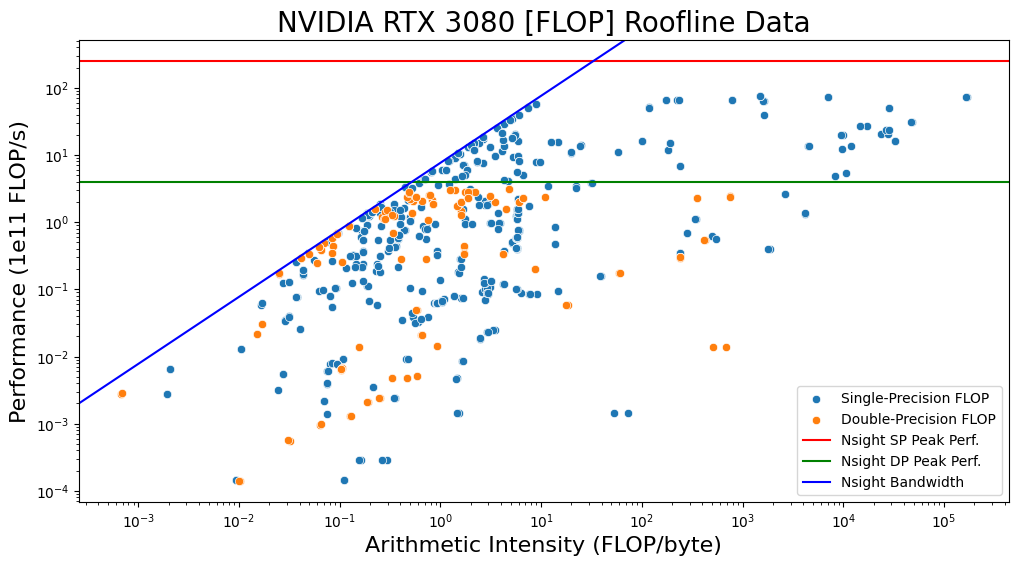

In [7]:
# it should be noted that samples with dpAI=0 and dpPerf=0 will not show on this plot
fig, ax = plt.subplots(1, figsize=(12,6))

sns.scatterplot(df, x='spAI', y='spPerf', ax=ax)
sns.scatterplot(df, x='dpAI', y='dpPerf', ax=ax)


ax.axhline(249.6,color='red')
ax.axhline(3.9,color='green')

ax.axline(xy1=(0.51,3.9), xy2=(32.94, 249.6), color='blue')

#ax.plot([0.00001, 32.94], [0.00757, 249.6], color='blue')

ax.set_yscale('log')
ax.set_xscale('log')

#ax.axvline(0.51)
#ax.axvline(32.94)

ax.set_title('NVIDIA RTX 3080 [FLOP] Roofline Data', fontsize=20)

ax.set_xlabel('Arithmetic Intensity (FLOP/byte)', fontsize=16)
ax.set_ylabel('Performance (1e11 FLOP/s)', fontsize=16)

ax.legend(['Single-Precision FLOP', 'Double-Precision FLOP', 'Nsight SP Peak Perf.', 'Nsight DP Peak Perf.', 'Nsight Bandwidth'])

plt.show()

Notice how the NVIDIA-reported roofline looks very similar to our rooflines!

Their DP roofline is just under 10e11 FLOP/s (so is ours!) 
Their SP roofline is just above 100e11 FLOP/s -- ours is actually just under 100e11.

We essenitally just performed an empirical roofline gathering! 

### Note
The NVIDIA rooflines are based on empirical data that they seem to gather on-the-fly, as the rooflines seem to change slightly across ncu reports.

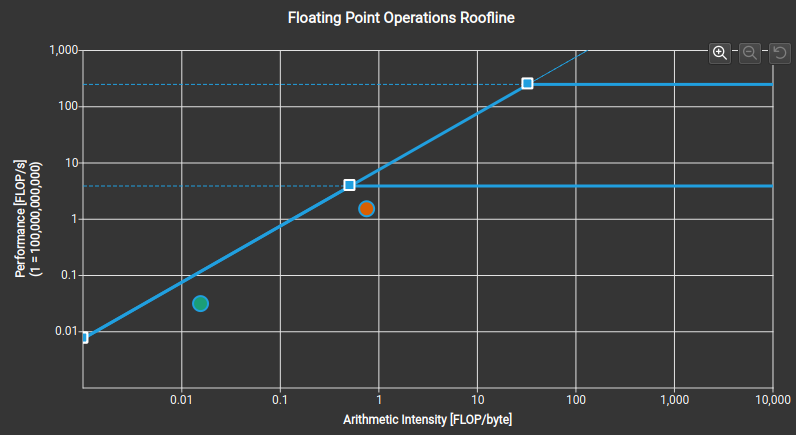

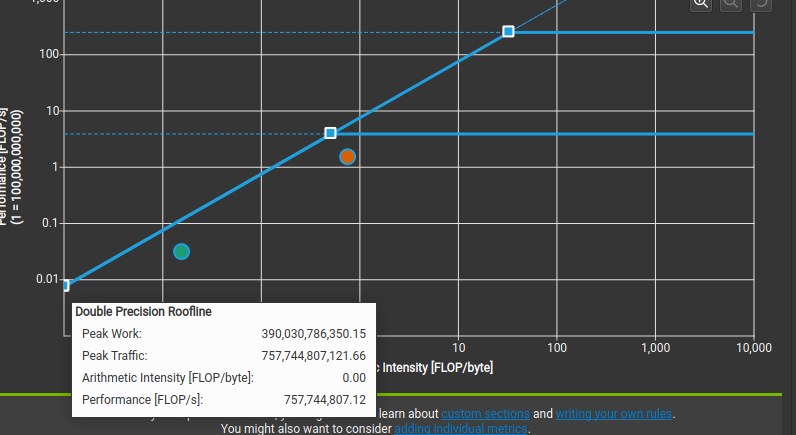

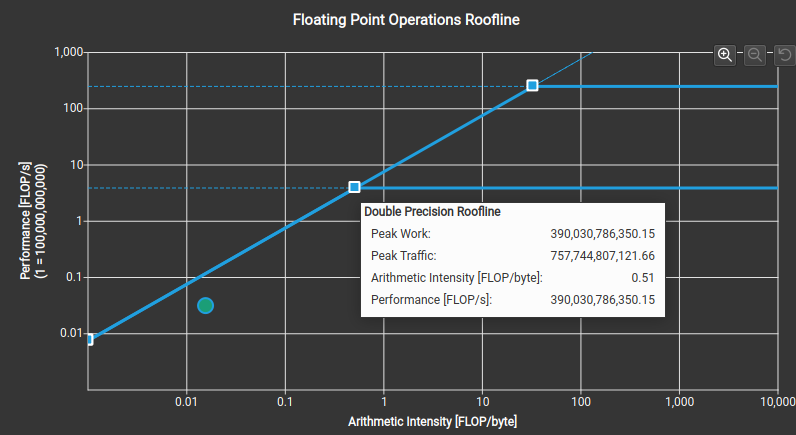

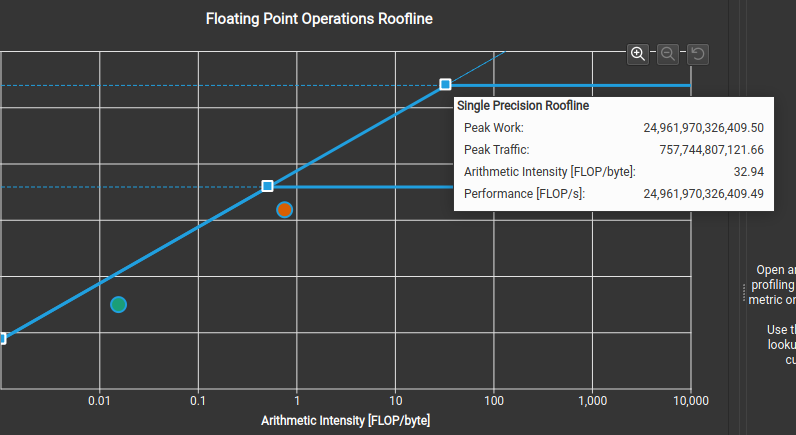

### Let's get some statistics about the data

In [8]:
print(df.columns)


Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName'],
      dtype='object')


In [9]:
# how many different kernel invocations did we capture?
totalExes = df.groupby(['targetName', 'device', 'exeArgs']).ngroups
print(f'Total unique executables sampled: {totalExes}')

totalKernels = df.groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Total unique kernel executions recorded: {totalKernels}')

zeroAIKernels = df[(df['spAI'] == 0.0) & (df['dpAI'] == 0.0)].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
print(f'Number of kernels with no arithmetic intensity (AI) {zeroAIKernels} ({round(100*zeroAIKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero AI single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numSPKernels = df[df['spPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numDPKernels = df[df['dpPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups

print(f'Number of non-zero Perf single-precision kernels recorded: {numSPKernels} ({round(100*numSPKernels/totalKernels, 2)}%)')
print(f'Number of non-zero Perf double-precision kernels recorded: {numDPKernels} ({round(100*numDPKernels/totalKernels, 2)}%)')

numIntPerfKernels = df[df['intPerf'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups
numIntAIKernels = df[df['intAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs']).ngroups


print(f'Number of non-zero Perf intop kernels recorded: {numIntPerfKernels} ({round(100*numIntPerfKernels/totalKernels, 2)}%)')
print(f'Number of non-zero AI intop kernels recorded: {numIntAIKernels} ({round(100*numIntAIKernels/totalKernels, 2)}%)')



Total unique executables sampled: 210
Total unique kernel executions recorded: 604
Number of kernels with no arithmetic intensity (AI) 266 (44.04%)
Number of non-zero AI single-precision kernels recorded: 289 (47.85%)
Number of non-zero AI double-precision kernels recorded: 83 (13.74%)
Number of non-zero Perf single-precision kernels recorded: 289 (47.85%)
Number of non-zero Perf double-precision kernels recorded: 83 (13.74%)
Number of non-zero Perf intop kernels recorded: 604 (100.0%)
Number of non-zero AI intop kernels recorded: 604 (100.0%)


In [10]:
spData = df[(df['spAI'] > 0)]
dpData = df[(df['dpAI'] > 0)]

#subdata = df[(df['spPerf'] > 0) | (df['dpPerf'] > 0) | (df['spAI'] > 0) | (df['dpAI'] > 0) ]
print('SP data')
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].max(axis=0))
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].min(axis=0))
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].median(axis=0))
print(spData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].mean(axis=0))

print()
print('DP data')
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].max(axis=0))
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].min(axis=0))
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].median(axis=0))
print(dpData[['spPerf', 'dpPerf', 'spAI', 'dpAI']].mean(axis=0))

SP data
spPerf        75.278073
dpPerf         3.140706
spAI      167276.896517
dpAI         748.873518
dtype: float64
spPerf    0.000143
dpPerf    0.000000
spAI      0.001921
dpAI      0.000000
dtype: float64
spPerf    0.923191
dpPerf    0.000000
spAI      1.595144
dpAI      0.000000
dtype: float64
spPerf       6.448810
dpPerf       0.169115
spAI      1471.651023
dpAI         8.137125
dtype: float64

DP data
spPerf      29.306288
dpPerf       3.140706
spAI      4584.355783
dpAI       748.873518
dtype: float64
spPerf    0.000000
dpPerf    0.000140
spAI      0.000000
dpAI      0.000676
dtype: float64
spPerf    0.000000
dpPerf    0.441651
spAI      0.000000
dpAI      0.576224
dtype: float64
spPerf     0.774887
dpPerf     0.955681
spAI      64.874386
dpAI      37.547376
dtype: float64


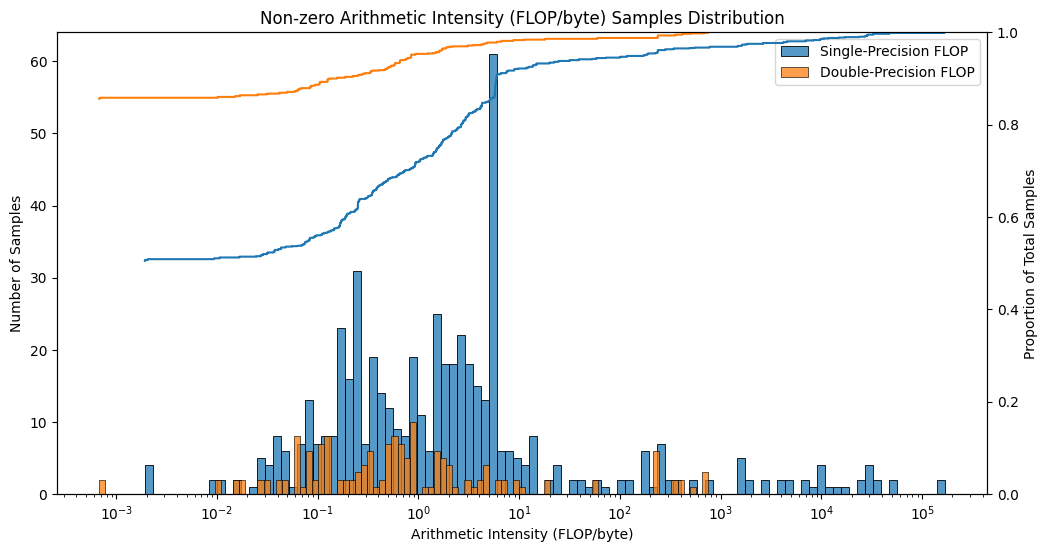

In [11]:
# what does the AI distribution look like? (violin plot + histogram)

fig, ax = plt.subplots(1, figsize=(12,6))

sns.histplot(df, x='spAI', bins=100, ax=ax, log_scale=True)
sns.histplot(df, x='dpAI', bins=100, ax=ax, log_scale=True)
ax2 = ax.twinx()
sns.ecdfplot(df, x='spAI', ax=ax2)
sns.ecdfplot(df, x='dpAI', ax=ax2)

ax.set_xlabel('Arithmetic Intensity (FLOP/byte)')
ax.set_ylabel('Number of Samples')
ax2.set_ylabel('Proportion of Total Samples')

ax.set_title('Non-zero Arithmetic Intensity (FLOP/byte) Samples Distribution')

ax.legend(['Single-Precision FLOP', 'Double-Precision FLOP'])

plt.show()

In [12]:
#subdf = df[df['targetName'].isin(['bspline-vgh-cuda'])].copy().reset_index()
#
#print(subdf)
#
#print(type(subdf.iloc[0]['exeArgs']))
#
#grpA = subdf[subdf['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size', 'exeArgs'])
#grpB = subdf[subdf['spAI'] > 0.0].groupby(['Kernel Name', 'kernelName', 'targetName', 'device', 'Block Size', 'Grid Size'])
#
#
#print(grpA)
#print(grpB)
#
#print(grpA.ngroups)
#print(grpB.ngroups)

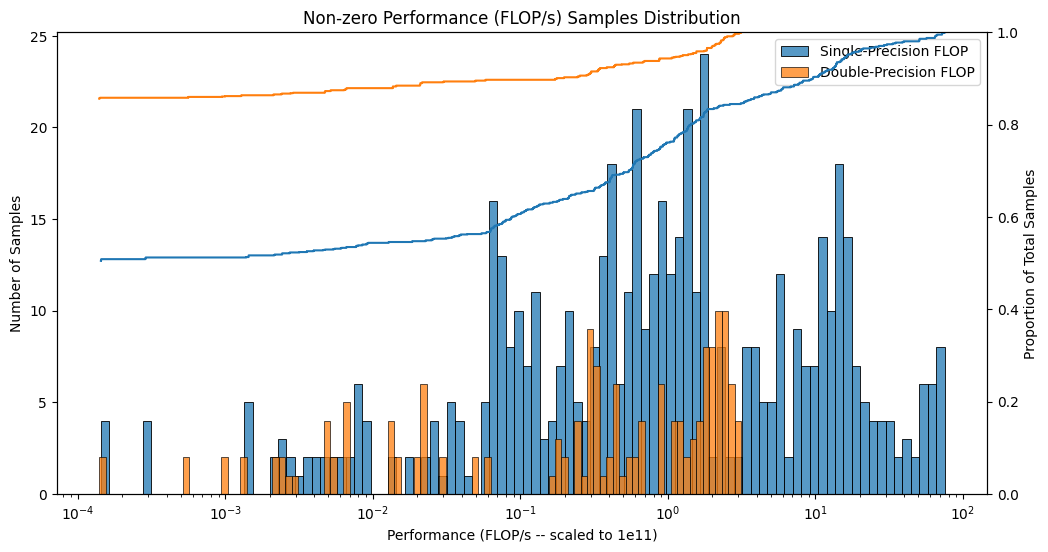

In [13]:
# what does the AI distribution look like? (violin plot + histogram)

fig, ax = plt.subplots(1, figsize=(12,6))

sns.histplot(df, x='spPerf', bins=100, ax=ax, log_scale=True)
sns.histplot(df, x='dpPerf', bins=100, ax=ax, log_scale=True)
ax2 = ax.twinx()
sns.ecdfplot(df, x='spPerf', ax=ax2)
sns.ecdfplot(df, x='dpPerf', ax=ax2)

ax.set_xlabel('Performance (FLOP/s -- scaled to 1e11)')
ax.set_ylabel('Number of Samples')
ax2.set_ylabel('Proportion of Total Samples')

ax.set_title('Non-zero Performance (FLOP/s) Samples Distribution')

ax.legend(['Single-Precision FLOP', 'Double-Precision FLOP'])

plt.show()

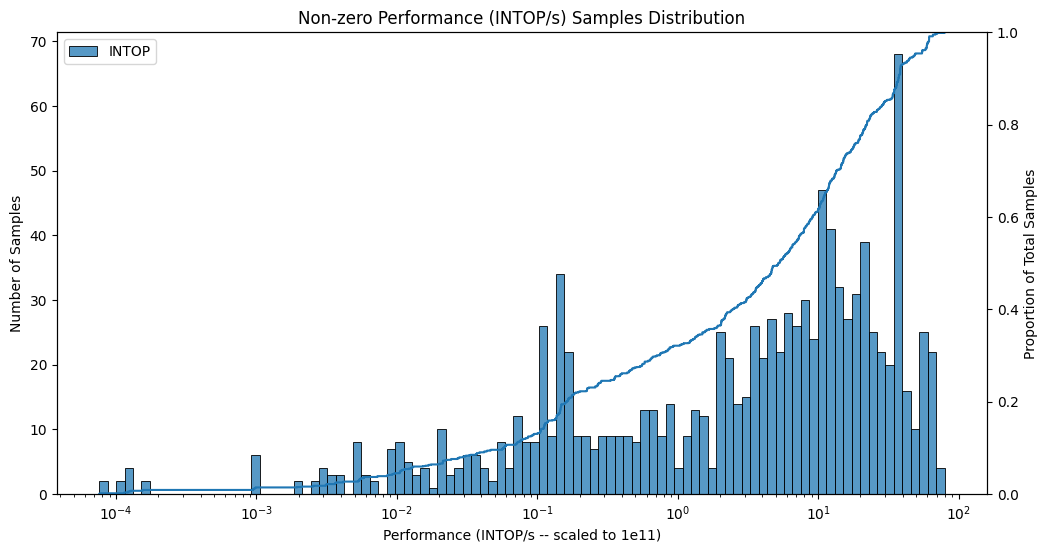

In [14]:
# what does the AI distribution look like? (violin plot + histogram)

fig, ax = plt.subplots(1, figsize=(12,6))

sns.histplot(df, x='intPerf', bins=100, ax=ax, log_scale=True)
ax2 = ax.twinx()
sns.ecdfplot(df, x='intPerf', ax=ax2)

ax.set_xlabel('Performance (INTOP/s -- scaled to 1e11)')
ax.set_ylabel('Number of Samples')
ax2.set_ylabel('Proportion of Total Samples')

ax.set_title('Non-zero Performance (INTOP/s) Samples Distribution')

ax.legend(['INTOP'])

plt.show()

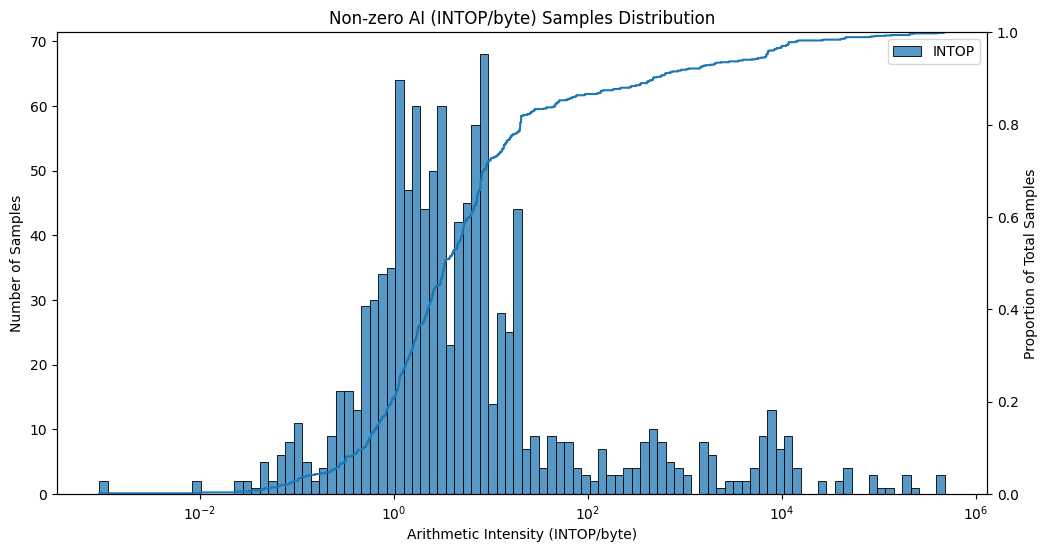

In [15]:
# what does the AI distribution look like? (violin plot + histogram)

fig, ax = plt.subplots(1, figsize=(12,6))

sns.histplot(df, x='intAI', bins=100, ax=ax, log_scale=True)
ax2 = ax.twinx()
sns.ecdfplot(df, x='intAI', ax=ax2)

ax.set_xlabel('Arithmetic Intensity (INTOP/byte)')
ax.set_ylabel('Number of Samples')
ax2.set_ylabel('Proportion of Total Samples')

ax.set_title('Non-zero AI (INTOP/byte) Samples Distribution')

ax.legend(['INTOP'])

plt.show()